---
title: "Calc 1: Newton's Method From The Ground Up"
date: 2023-01-15
draft: false
categories: ['Python Projects']
tags: ['Python', 'Math']
math: true
---

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sympy
import imageio
import os
from typing import Callable


## Newton's Method for Finding Roots: What, How, and Why

>The idea is to start with an initial guess, then to approximate the function by its tangent line, and finally to compute the x-intercept of this tangent line. This x-intercept will typically be a better approximation to the original function's root than the first guess, and the method can be iterated.  

-- [Newton's Method Wikipedia Page](https://en.wikipedia.org/wiki/Newton%27s_method)


### Using Newton's Method to Solve a Simple Problem

In [22]:
x, y = sympy.symbols('x y')
y = 4*sympy.sin(x)
y

4*sin(x)

In [23]:
sympy.solveset(y, x, sympy.Interval(-5, -1))

{-pi}

\begin{align*}
4 \sin{\left(x \right)} &= 0 \quad where \quad -5\leq x \leq -1\\
\sin{\left(x \right)} &= 0 \\
x &= -\pi
\end{align*}

{{< details "Utility functions" >}}

In [24]:
def plot_f(
    f: Callable[[float], float],
    x_low: int,
    x_high: int,
    ax: matplotlib.axes.Axes) -> None:
    """
    Plots a given function f within a specified range on a provided axes.

    Parameters:
        f (Callable[[float], float]): The function to be plotted.
        x_low (int): The lower bound of the x-axis.
        x_high (int): The upper bound of the x-axis.
        ax (matplotlib.axes.Axes): The matplotlib axes object on which the function will be plotted.

    Returns:
        None
    """
    x_vec = np.linspace(x_low, x_high, 100)
    ax.plot(x_vec, f(x_vec))

def base_plot(
    y: sympy.core.mul.Mul,
    x: sympy.core.mul.Mul,
    x_low: int=-5,
    x_high: int=5) -> None:
    """
    Creates a base plot for a mathematical expression and its graph.

    Parameters:
        y (sympy.core.mul.Mul): The mathematical expression to be plotted.
        x (sympy.core.mul.Mul): The symbol representing the independent variable in the expression.
        x_low (int): The lower bound of the x-axis (default is -5).
        x_high (int): The upper bound of the x-axis (default is 5).

    Returns:
        tuple: A tuple containing the matplotlib figure and axes used for plotting.

    Note:
        The mathematical expression is first converted to a Python function using sympy.lambdify.
    The function is then plotted on the specified axes along with gridlines and labels.
    """
    f = sympy.lambdify(x, y)
    fig, ax = plt.subplots()
    ax.grid(alpha=.5)
    ax.axhline(0, color="black", alpha=.5)
    plot_f(f, x_low, x_high, ax)
    ax.set(title=f"$f(x)={sympy.latex(y)}$", xlabel="$x$", ylabel="$f(x)$")
    return fig, ax

def plot_truth(ax: matplotlib.axes.Axes) -> None:
    """
    Plots the true root of a function as a marker on the graph.

    Parameters:
        ax (matplotlib.axes.Axes): The matplotlib axes on which the marker will be plotted.

    Returns:
        None
    """
    ax.plot(-np.pi,
        0,
        "*",
        markersize=15,
        color="darkblue",
        label="True root, $-\pi$")
    
def plot_guess(
    ax: matplotlib.axes.Axes,
    guess: int,
    label: str) -> None:
    """
    Plots a guess or estimate as a marker on the graph.

    Parameters:
        ax (matplotlib.axes.Axes): The matplotlib axes on which the marker will be plotted.
        guess (int): The estimated value to be marked on the graph.
        label (str): Label for the marker.

    Returns:
        None
    """
    ax.plot(guess,
            0,
            "o",
            label=label)
    
def plot_guess_coords(
    ax: matplotlib.axes.Axes,
    guess: int,
    label: str,
    y: sympy.core.mul.Mul=y,
    x: sympy.core.mul.Mul=x):
    """
    Plots a guess or estimate with specific coordinates as a marker on the graph.

    Parameters:
        ax (matplotlib.axes.Axes): The matplotlib axes on which the marker will be plotted.
        guess (int): The estimated x-coordinate where the marker will be placed.
        label (str): Label for the marker.
        y (sympy.core.mul.Mul): The mathematical expression corresponding to the y-coordinate.
        x (sympy.core.mul.Mul): The symbol representing the independent variable (x).

    Returns:
        None
    """
    ax.plot(guess,
            y.subs(x, guess).evalf(),
            "s",
            label=label, color="black")
    
def euclidean_dist_to_truth(x): return np.sqrt((-np.pi - float(x))**2)

{{< /details >}}

#### Step 1: Make a first guess and evaluate its (x, y) coordinates

In [25]:
x_0 = -2
x_0


-2

$$
\begin{align*}
f(x) &= 4 \sin \left( x \right) \\
f(x_0) &= 4 \sin \left( -2 \right) \\
f(x_0) &\approx −3.6371897 \\
(x_0, y_0) &= (x_0, f(x_0)) \approx (-2, −3.6371897) 
\end{align*}
$$

In [26]:
(x_0, y.subs(x, x_0).evalf(8))


(-2, -3.6371897)

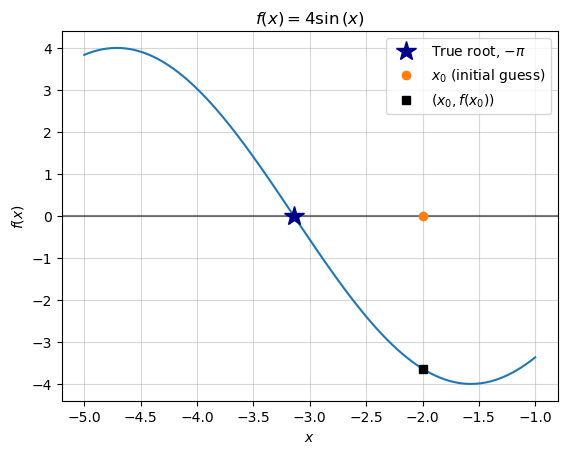

In [27]:
fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
plot_truth(ax)
plot_guess(ax, x_0, "$x_0$ (initial guess)")
plot_guess_coords(ax, x_0, "$(x_0, f(x_0))$")
ax.legend();


#### Step 2: Find the equation of the tangent line at those coordinates
$$
\begin{align*}
f(x) &= 4 \sin \left( x \right) \\
f'(x) &= 4 \cos \left( x \right) \\
f'(x_0) &= 4 \cos \left( -2 \right) \\
f'(x_0) &\approx −1.6645873
\end{align*}
$$

In [28]:
print("   f(x) = ", y)
print("  f'(x) = ", y.diff())
print("f'(x_0) = ", y.diff().subs(x, -2))
print("[note: sympy converted x_0=-2 to x_0=2 because cos(-x)=cos(x)]")
print("f'(x_0) = ", y.diff().subs(x, x_0).evalf())


   f(x) =  4*sin(x)
  f'(x) =  4*cos(x)
f'(x_0) =  4*cos(2)
[note: sympy converted x_0=-2 to x_0=2 because cos(-x)=cos(x)]
f'(x_0) =  -1.66458734618857


Given each of these terms:
|  Term   | Value |
| -------- | ------- |
| $x_0$  | $= -2$   |
| $f(x_0)$ | $\approx −3.6371897$     |
| $f'(x_0)$    | $\approx −1.6645873$   |   

We can proceed to find the full equation of the tangent line by writing out the point-slope form of a linear equation with slope $m=f'(x_0)$.
$$
\begin{align*}
(y - y_0) &= m(x - x_0) \\
(y - f(x_0)) &= f'(x_0)(x - x_0) \\
y &= f'(x_0)(x - x_0) + f(x_0)
\end{align*}
$$
Plugging in our values, we get:
$$
\begin{align*}
y &\approx −1.6645873x + 1.6645873(-2) - 3.6371897\\
y &\approx −1.6645873x - 6.9663643\\
\end{align*}
$$  

We'll save that into a python function and plot it to make sure it does look like the tangent.

In [29]:
def f_1(x): return -1.6645873*x - 6.9663643


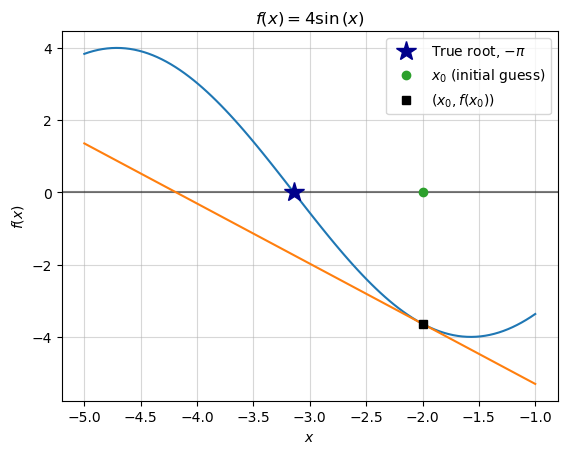

In [30]:
fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
plot_truth(ax)

plot_f(f_1, x_low=-5, x_high=-1, ax=ax)

plot_guess(ax, x_0, "$x_0$ (initial guess)")
plot_guess_coords(ax, x_0, "$(x_0, f(x_0))$")

ax.legend();


#### Step 3: Find the x-intercept of the tangent line
Given that the tangent line is the **best linear approximation** of the original function, we can use its x-intercept as an approximation of the x-intercept of the original function. Thus, the root of the tangent line is the new "best-guess" of the original function's root.

$$
\begin{align*}
0 &\approx −1.6645873x_1 - 6.9663643\\
\frac{6.9663643}{−1.6645873} &\approx x_1\\
x_1 &\approx -4.1850
\end{align*}
$$

In [31]:
x_1 = -4.1850


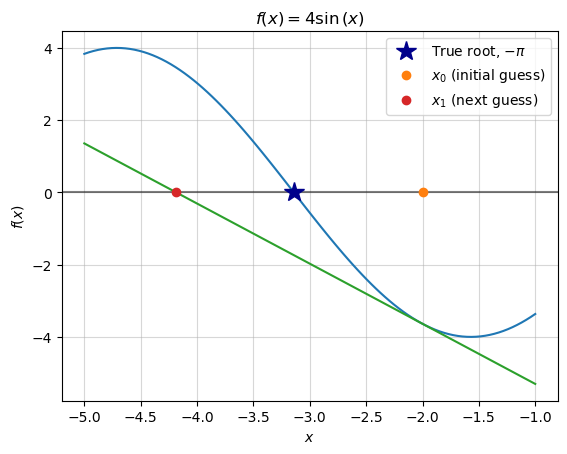

In [32]:
fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
plot_truth(ax)
plot_guess(ax, x_0, "$x_0$ (initial guess)")
plot_f(f_1, x_low=-5, x_high=-1, ax=ax)
plot_guess(ax, x_1, "$x_1$ (next guess)")
ax.legend();


While this guess still isn't particularly great, we can see that we have actually reduced the "error" of our guess:

In [149]:
for i, x_n in enumerate([x_0, x_1]):
    print(f"error for guess x_{i}:", euclidean_dist_to_truth(x_n))

error for guess x_0: 1.1415926535897931
error for guess x_1: 1.0434073464102065


The big reveal of Newton-Raphson is that this error will continue to shrink as we repeat steps 1-3.

#### Step 4: Repeat
We will again find the tangent line at this new point, $(x_1, f(x_1))$. We could take the old tangent line equation, $y = f'(x_0)(x - x_0) + f(x_0)$ and simply update all of those $x_0$ to $x_1$, but at this point it will benefit us to move towards a more general equation: 
$$
y = f'(x_n)(x - x_n) + f(x_n)
$$
That allows us to generate the tangent line at any given guess $x_n$. The following code leverages `sympy` to write that equation as a python function. 

In [57]:
def y_n(x_n): return (
    y.diff().subs(x, x_n) * (x - x_n) +  # f_1(x_1)(x-x_1) +
    y.subs(x, x_n)  # f(x_1)
)


In [58]:
y_n(x_1)


-2.01311525745113*x - 4.96839101072835

In [59]:
x_2 = sympy.solve(y_n(x_1), x)[0]
x_2


-2.46801120419652

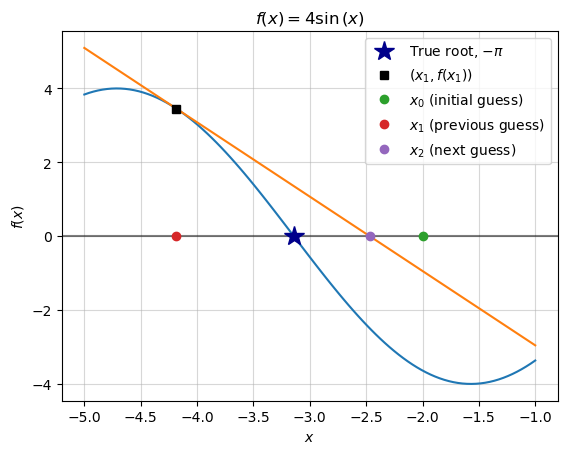

In [38]:
fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
plot_truth(ax)
plot_f(sympy.lambdify(x, y_n(x_1)), x_low=-5, x_high=-1, ax=ax)

plot_guess_coords(ax, x_1, "$(x_1, f(x_1))$")

plot_guess(ax, x_0, "$x_0$ (initial guess)")
plot_guess(ax, x_1, "$x_1$ (previous guess)")
plot_guess(ax, x_2, "$x_2$ (next guess)")

ax.legend();


In [40]:
for i, x_n in enumerate([x_0, x_1, x_2]):
    print(f"error for guess x_{i}:", euclidean_dist_to_truth(x_n))

error for guess x_0: 1.1415926535897931
error for guess x_1: 1.0434073464102065
error for guess x_2: 0.6735814493932737


At this point, it becomes important that we move away from calculating each step manually and move towards a generalizable equation and algorithm.

#### Step 5: Generalize the procedure

##### Make the equation more direct
Thus far we have used the general equation $y = f'(x_n)(x - x_n) + f(x_n)$, where $x_n$ is our current guess, and we solve for $x$ to define our next guess. Given that we solve the equation for $x$, we can rewrite it as follows:  
$$
\begin{align*}
0 &= f'(x_n)(x - x_n) + f(x_n)\\
0 &= f'(x_n)(x - x_n) + f(x_n) \\
0 - f(x_n) &= f'(x_n)(x - x_n)\\
-\frac{f(x_n)}{f'(x_n)} &= x - x_n\\
x &= x_n -\frac{f(x_n)}{f'(x_n)}\\
\end{align*}
$$
This expresses *one step* of Newton's Method -- solving for the x-intercept of the tangent line at the point $(x_n, f(x_n))$.  

##### From equation to algorithm

We now build on this single step and express the general *process* of Newton's method. To start, it's more accurate to label the left hand side $x_{n+1}$ given that it represents the next guess:
$$
x_{n+1} = x_n -\frac{f(x_n)}{f'(x_n)}
$$  
Given this equation, we can think of Newton-Raphson as essentially searching for good guesses until it's right. But how do we define "right"? Put in other words, **when do we stop?** In our case, we are working with a simple function and we know the correct answer -- we can just stop once we get close to that answer -- but in any real application that won't be the case. In those cases, it is common practice to define "right" as when the guesses stop changing much with each iteration. Stated semi-formally, we wait until this: $|x_{n+1} - x_{n}|$ gets small.  

For example: if the last guess was -3.14159 and the new guess is -3.141592, the guess only changed by .0000002, and we might conclude that we've gotten as close to the answer as is necessary. In this case, we set a stopping condition -- when the next guess is less than or equal to .0000002 away from the previous one, we stop. We can write out the stopping condition as follows:
$$
\begin{align*}
|x_{n+1} - x_{n}| &\leq 2\times 10^{-6} \\
|(x_n -\frac{f(x_n)}{f'(x_n)}) - x_{n}| &\leq 2\times 10^{-6} \\
|-\frac{f(x_n)}{f'(x_n)}| &\leq 2\times 10^{-6} \\
|\frac{f(x_n)}{f'(x_n)}| &\leq 2\times 10^{-6}
\end{align*}
$$
and we can try writing out the recursive algorithm as a piece-wise equation:
$$
\text{Let } x_0 := \text{initial guess} \text{. For all natural numbers } n \ge 0 \text{, define }  x_{n+1} \text{ as:} \\

x_{n+1} =
    \begin{cases}
        x_n & \text{if }\quad |\frac{f(x_n)}{f'(x_n)}| \leq 2\times 10^{-6} \\
        x_n -\frac{f(x_n)}{f'(x_n)} & \text{Otherwise}
    \end{cases}

$$


In [63]:
x_n = -2
guesses = []
errors = []

counter = 1
while True:
    # Disregard the following utility code
    guesses.append(x_n)
    errors.append(euclidean_dist_to_truth(x_n))
    print(f"Guess {counter}:",
          str(round(float(x_n), 5)).ljust(8, '0'),
          " --- Error:",
          euclidean_dist_to_truth(x_n))
    
    # The following is the code for newton's method
    if np.abs(sympy.lambdify(x, y)(x_n) / sympy.lambdify(x, y.diff())(x_n)) < 2e-6:
        print(f"Converged in {counter} steps.")
        break
    x_n = x_n - (
        sympy.lambdify(x, y)(x_n) /
        sympy.lambdify(x, y.diff())(x_n)
    )
        
    counter += 1


Guess 1: -2.00000  --- Error: 1.1415926535897931
Guess 2: -4.18504  --- Error: 1.0434472096717258
Guess 3: -2.46789  --- Error: 0.6736989790751275
Guess 4: -3.26619  --- Error: 0.1245936239793135
Guess 5: -3.14094  --- Error: 0.00064874127215786
Guess 6: -3.14159  --- Error: 9.101119857746198e-11
Converged in 6 steps.


{{< details "Code for GIF generation" >}}

In [57]:
%%capture
x_n = -2
max_iter = 10
tolerance = 1e-6

fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
plot_truth(ax)
ax.set_ylim(-4, 4)
ax.set_xlim(-4.5, -1.5)

images = []
breaking_condition = False
for j in range(max_iter):
    error = euclidean_dist_to_truth(x_n)
    if error < tolerance:
        breaking_condition = True

    ax.set_title(
        f"Iteration {j+1}\nGuess: {round(x_n, 6)}\n Error: {round(error, 8)}")

    # Plot the current guess
    plot_guess(ax, x_n, "$x_n$")
    filename = f'newton_iteration_{j}_0.png'
    fig.savefig(filename)
    images.append(imageio.imread(filename))

    if breaking_condition:
        ax.text(x_n, 2, s=f"CONVERGED IN {j} STEPS", size=15)
        filename = f'newton_iteration_{i}_3.png'
        fig.savefig(filename)
        images.append(imageio.imread(filename))
        ax.text(x_n, 2, s=f"CONVERGED IN {j} STEPS", size=15)
        filename = f'newton_iteration_{i}_4.png'
        fig.savefig(filename)
        images.append(imageio.imread(filename))
        break
    # Plot the coordinates of the current guess
    plot_guess_coords(ax, x_n, "$(x_n, f(x_n))$")
    filename = f'newton_iteration_{j}_1.png'
    fig.savefig(filename)
    images.append(imageio.imread(filename))
    # Plot the tangent line of that coordinate to inform next guess
    plot_f(sympy.lambdify(x, y_n(x_n)), x_low=-5, x_high=-1, ax=ax)
    filename = f'newton_iteration_{j}_2.png'
    fig.savefig(filename)
    images.append(imageio.imread(filename))

    # Reset plot
    ax.clear()
    fig, ax = base_plot(y, x, x_low=-5, x_high=-1)
    plot_truth(ax)
    ax.set_ylim(-4, 4)
    ax.set_xlim(-4.5, -1.5)

    x_n -= (
        sympy.lambdify(x, y)(x_n) /
        sympy.lambdify(x, y.diff())(x_n)
    )
imageio.mimsave('newton_iterations.gif', images, duration=1)

# Clean out pngs
wd = os.getcwd()
files = os.listdir(wd)
for item in files:
    if item.endswith(".png"):
        os.remove(os.path.join(wd, item))


{{< /details >}}

![gif](newton_iterations.gif?4 "gif")

### Using Newton's Method to Solve a Real Problem
In the previous example, we dealt with a function, $f(x) = 4\sin(x)$ with a known analytical solution. Other simple functions can typically be solved with known formulas -- e.g. a second degree polynomial's roots can be found using the quadratic formula. However, this is not always the case. For example, if $f(x)$ is a polynomial of degree 5 or greater, it is known that no formula for finding its roots exist. Consider the following polynomial of degree 5:
$$
f(x) =x^{5} + 8 x^{4} + 4 x^{3} - 2 x - 7
$$
What if we are asked to solve the following:
$$
\begin{align*}
f(x)&=0 \quad where -5\leq x \leq 0\\
0 &=  x^{5} + 8 x^{4} + 4 x^{3} - 2 x - 7 \quad where -5\leq x \leq 0\\
\end{align*}
$$
There is no formula that solves this. Indeed, even plugging the polynomial into `sympy` and running its solver, `sympy.solveset`, doesn't give a clear answer.

In [180]:
x, y = sympy.symbols('x y')
y = x**5 + 8*x**4 + 4*x**3 - 2*x-7
y

x**5 + 8*x**4 + 4*x**3 - 2*x - 7

In [181]:
sympy.solveset(y, x, sympy.Interval(-5, 0))

{CRootOf(x**5 + 8*x**4 + 4*x**3 - 2*x - 7, 1)}

Where $\text{CRootOf}$ is an indexed complex root of the polynomial -- not an analytical solution.

In [144]:
x_vec = np.linspace(-5, 0, 1000000)

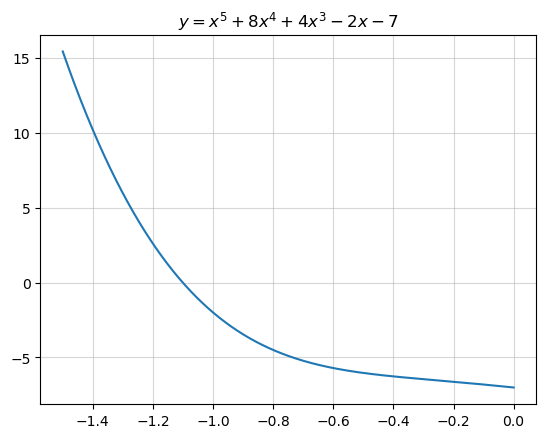

In [182]:
fig, ax = plt.subplots()
ax.grid(alpha=.5)
ax.plot(x_vec, sympy.lambdify(x, y)(x_vec))
ax.set_title(f"$y={sympy.latex(y)}$");


In [157]:
x_n = 0

tolerance = 1e-10
counter = 1


while True:
    # Disregard the following utility code
    print(f"Guess {counter}:",
          str(round(float(x_n), 5)).ljust(8, '0'),
          " --- Error:",
          euclidean_dist_to_truth(x_n))
    
    # The following is the code for newton's method
    if np.abs(sympy.lambdify(x, y)(x_n) / sympy.lambdify(x, y.diff())(x_n)) < tolerance:
        print(f"Converged in {counter} steps.")
        break
    x_n = x_n - (
        sympy.lambdify(x, y)(x_n) /
        sympy.lambdify(x, y.diff())(x_n)
    )
        
    counter += 1

Guess 1: 0.000000  --- Error: 3.141592653589793
Guess 2: -3.50000  --- Error: 0.3584073464102069
Guess 3: -2.44316  --- Error: 0.6984302043961392
Guess 4: -1.81481  --- Error: 1.3267800055437047
Guess 5: -1.41471  --- Error: 1.726886024726261
Guess 6: -1.19062  --- Error: 1.9509769810235635
Guess 7: -1.11070  --- Error: 2.0308902060887837
Guess 8: -1.10108  --- Error: 2.0405099013561894
Guess 9: -1.10095  --- Error: 2.0406396683000647
Guess 10: -1.10095  --- Error: 2.040639691648806
Converged in 10 steps.


In [167]:
x_n

-1.1009529619409872

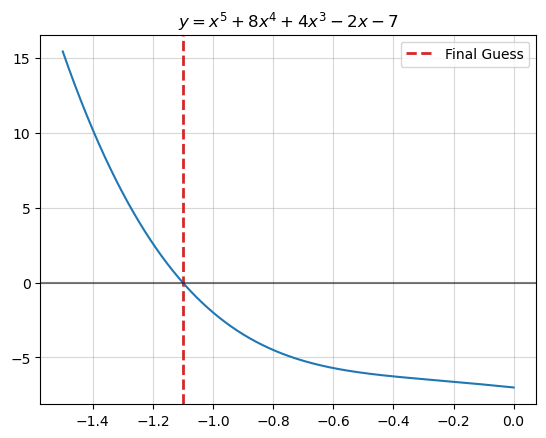

In [195]:
fig, ax = plt.subplots()

ax.axvline(x_n, linestyle="--", color="tab:red", linewidth=2, label="Final Guess")
ax.legend()

x_vec = np.linspace(-1.5, 0, 1000000)

ax.grid(alpha=.5)
ax.plot(x_vec, sympy.lambdify(x, y)(x_vec))
ax.set_title(f"$y={sympy.latex(y)}$")
ax.axhline(0, color="black", alpha=.5);

In [184]:
x_n

-1.1009529619409872

In [173]:
[sol.evalf() for sol in sympy.solveset(y, x, sympy.Interval(-5, 0))]

[-1.10095296194099]

## Newton's Method as Optimization
Recall that the derivative of a function is 0 at a critical point -- its maximum or minimum. We have been using Newton's Method to find the root of a function, but in the process we've been optimizing the anti-derivative, or, integral of that function. For visual intuition of this fact, consider the following plot, in which we visualize the integral of our function, $f(x) x^{5} + 8 x^{4} + 4 x^{3} - 2 x - 7$, and plot the same root of $f(x)$ that we just found using Newton's Method:

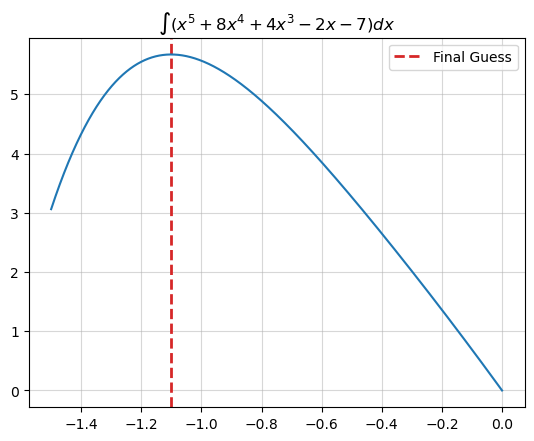

In [201]:
fig, ax = plt.subplots()

ax.axvline(x_n, linestyle="--", color="tab:red", linewidth=2, label="Final Guess")
ax.legend()

ax.grid(alpha=.5)
ax.plot(x_vec, sympy.lambdify(x, y.integrate())(x_vec))
ax.set_title(f"$\int ({sympy.latex(y)})dx$");

The root of $f(x)$ is clearly also the maximum of $\int f(x) dx$. From this fact, we can extend Newton's Method for general use in finding the critical value of a function as follows:
If the following equation will converge to the root of $f(x)$ and the optimal point of $\int f(x) dx$: 
$$
\begin{align*}
x_{n+1} = x_n -\frac{f(x_n)}{f'(x_n)}
\end{align*}
$$
Then the following equation will find the root of $f'(x)$ and thus the optimal point of $f(x)$:
$$
\begin{align*}
x_{n+1} = x_n -\frac{f'(x_n)}{f''(x_n)}
\end{align*}
$$